<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [56]:
# Import libraries for data wrangling, preprocessing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [57]:
# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

Read in file

In [58]:
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (1).csv


In [59]:
sns.set_style('dark')
import matplotlib as mpl
mpl.style.use(['https://gist.githubusercontent.com/BrendanMartin/01e71bb9550774e2ccff3af7574c0020/raw/6fa9681c7d0232d34c9271de9be150e584e606fe/lds_default.mplstyle'])
mpl.rcParams.update({"figure.figsize": (8,6), "axes.titlepad": 22.0})

Data Exploration

Unique values of the target variable ['no' 'yes']
Counts of the target variable : [36548  4640]


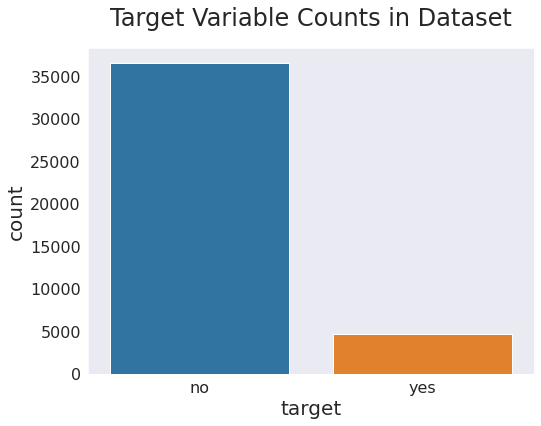

In [60]:
dataset.rename(columns = {'y':'target'}, inplace = True)

(unique, counts) = np.unique(dataset['target'], return_counts=True)

print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)

sns.countplot(data = dataset,x = 'target')
plt.title('Target Variable Counts in Dataset')
plt.show()

Turn categories to numerical

In [61]:
dataset.info()

dataset['target'] = pd.factorize(dataset['target'])[0] + 1
dataset['job'] = pd.factorize(dataset['job'])[0] + 1
dataset['marital'] = pd.factorize(dataset['marital'])[0] + 1
dataset['education'] = pd.factorize(dataset['education'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['housing'] = pd.factorize(dataset['housing'])[0] + 1
dataset['default'] = pd.factorize(dataset['default'])[0] + 1
dataset['loan'] = pd.factorize(dataset['loan'])[0] + 1
dataset['contact'] = pd.factorize(dataset['contact'])[0] + 1
dataset['month'] = pd.factorize(dataset['month'])[0] + 1
dataset['day_of_week'] = pd.factorize(dataset['day_of_week'])[0] + 1
dataset['poutcome'] = pd.factorize(dataset['contact'])[0] + 1

# Should remove - duration as only for benchmark
dataset = dataset.drop('duration', 1)

Handle Unbalance Data

In [62]:
yes = dataset[dataset.target == 1]
no = dataset[dataset.target == 2]

no = no.sample(n=len(yes), random_state=101,replace=True)
dataset = pd.concat([yes,no],axis=0)

Unique values of the target variable [1 2]
Counts of the target variable : [36548 36548]


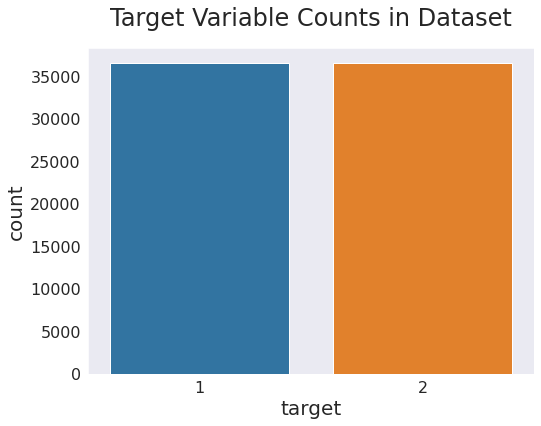

In [63]:
(unique, counts) = np.unique(dataset['target'], return_counts=True)

print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)

sns.countplot(data = dataset,x = 'target')
plt.title('Target Variable Counts in Dataset')
plt.show()

Pick Features

nr.employed      -0.467018
euribor3m        -0.447180
emp.var.rate     -0.430875
pdays            -0.307801
cons.price.idx   -0.197699
default          -0.173233
campaign         -0.123169
loan             -0.009043
housing           0.012862
day_of_week       0.016818
age               0.042730
marital           0.042755
education         0.074806
cons.conf.idx     0.077927
job               0.083963
contact           0.244196
poutcome          0.244196
month             0.257493
previous          0.257898
target            1.000000
Name: target, dtype: float64


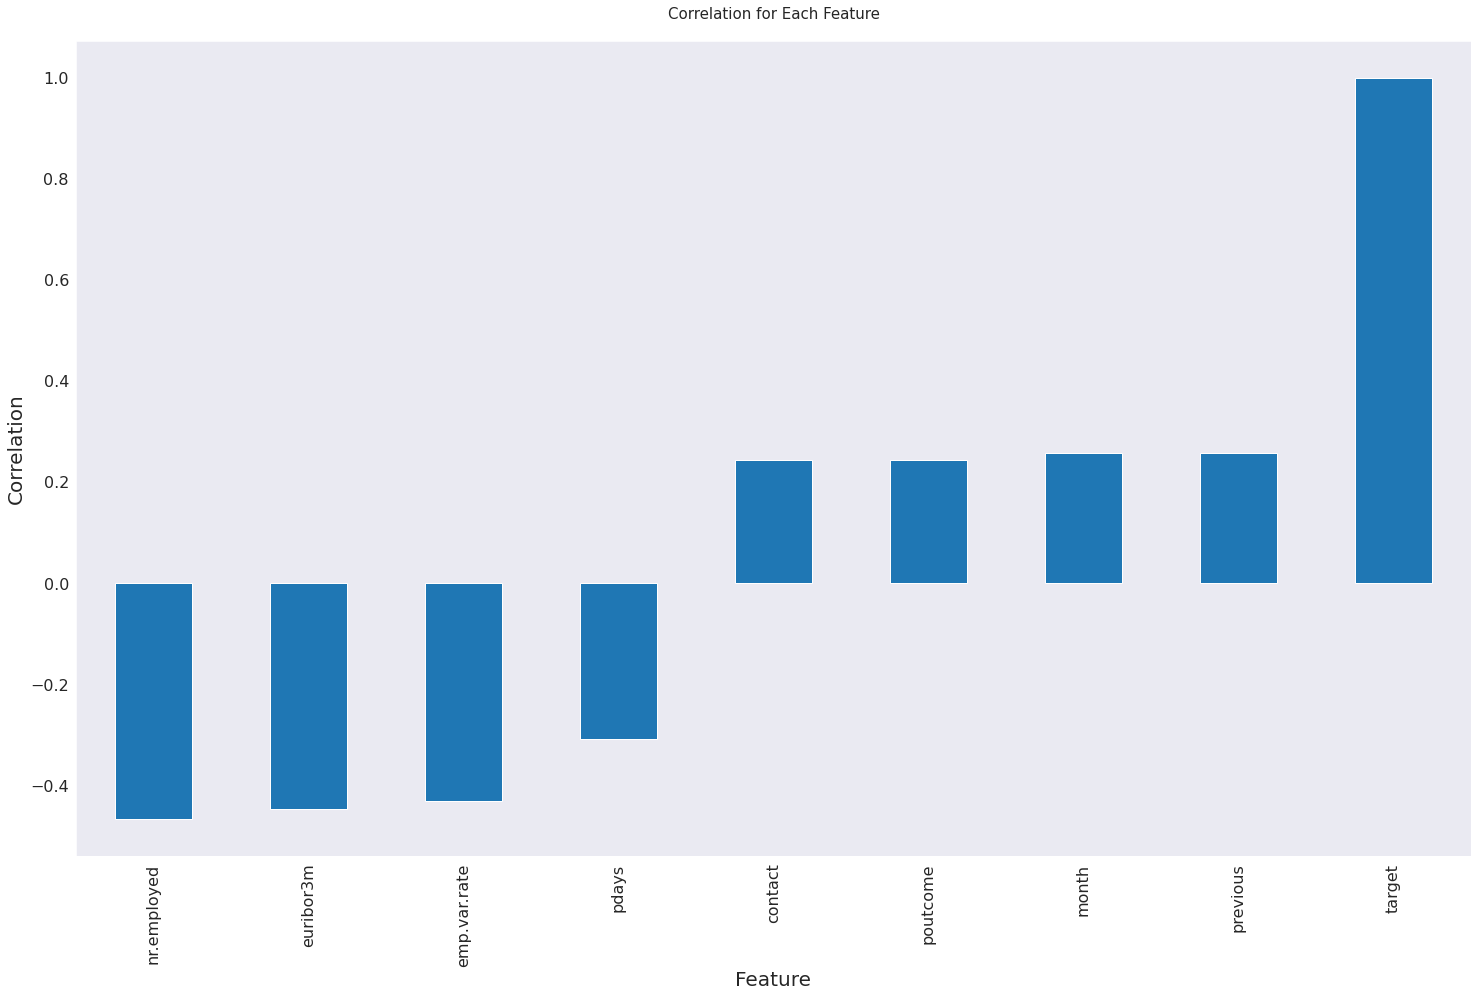

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [64]:
std_features_keep = dataset

# Create correlation matrix
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.2

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

std_features_keep = std_features_keep.drop(['target'], axis=1)
print(std_features_keep)

In [73]:
seed = 0
np.random.seed(seed)

In [80]:
X = std_features_keep  #Feature Matrix
# X = dataset[["contact", "previous"]]
y = dataset["target"]          #Target Variable

print(X.head())
print(y.head())

# Need to know no of inputs
number_of_features = len(X.columns)
print(type(X))

   contact  month  pdays  previous  poutcome  emp.var.rate  euribor3m  \
0        1      1    999         0         1           1.1      4.857   
1        1      1    999         0         1           1.1      4.857   
2        1      1    999         0         1           1.1      4.857   
3        1      1    999         0         1           1.1      4.857   
4        1      1    999         0         1           1.1      4.857   

   nr.employed  
0       5191.0  
1       5191.0  
2       5191.0  
3       5191.0  
4       5191.0  
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64
<class 'pandas.core.frame.DataFrame'>


Standardize

In [81]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

In [82]:
# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

Mean: 0
Standard deviation: 1.0


Create Neural Network

In [83]:
from keras import Sequential
from keras.layers import Dense
from keras import layers

classifier = Sequential()
# Add a dropout layer for input layer
classifier.add(layers.Dropout(0.2, input_shape=(number_of_features,)))
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=(number_of_features,)))
# Add a dropout layer for previous hidden layer
classifier.add(layers.Dropout(0.5))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
# Add a dropout layer for previous hidden layer
classifier.add(layers.Dropout(0.5))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
#Fitting the data to the training dataset
#We iterate over 3 epochs to train the model. An epoch is an iteration over the entire data set.
classifier.compile(optimizer ='rmsprop',loss='binary_crossentropy', metrics =['accuracy'])

Train Neural Network

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [85]:
# Train neural network
history = classifier.fit(X_train,y_train,epochs=10,
verbose=1, batch_size=100,validation_data=(X_test, y_test)) 


eval_model=classifier.evaluate(X_train, y_train)
eval_model

Epoch 1/10
512/512 [==============================] - 2s 3ms/step - loss: -0.8756 - accuracy: 0.4963 - val_loss: -3.8379 - val_accuracy: 0.5077
Epoch 2/10
512/512 [==============================] - 1s 2ms/step - loss: -11.5889 - accuracy: 0.4967 - val_loss: -22.7623 - val_accuracy: 0.5077
Epoch 3/10
512/512 [==============================] - 1s 2ms/step - loss: -44.1746 - accuracy: 0.4967 - val_loss: -68.6892 - val_accuracy: 0.5077
Epoch 4/10
512/512 [==============================] - 1s 2ms/step - loss: -110.8452 - accuracy: 0.4967 - val_loss: -153.6829 - val_accuracy: 0.5077
Epoch 5/10
512/512 [==============================] - 1s 2ms/step - loss: -225.2977 - accuracy: 0.4967 - val_loss: -289.7014 - val_accuracy: 0.5077
Epoch 6/10
512/512 [==============================] - 1s 2ms/step - loss: -386.1833 - accuracy: 0.4967 - val_loss: -487.6068 - val_accuracy: 0.5077
Epoch 7/10
512/512 [==============================] - 1s 2ms/step - loss: -642.0394 - accuracy: 0.4967 - val_loss: -761.

[-2178.98583984375, 0.49670687317848206]

In [8]:
# pip uninstall scipy
# for using eli6 for permutation importance
!pip install --upgrade --user scipy

  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


History of Loss

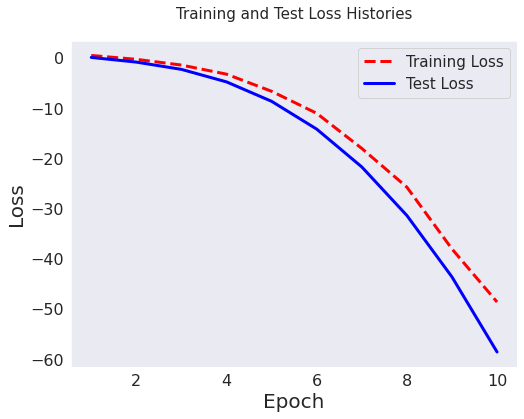

In [39]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

import matplotlib.pyplot as plt
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.title("Training and Test Loss Histories")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

History of Accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


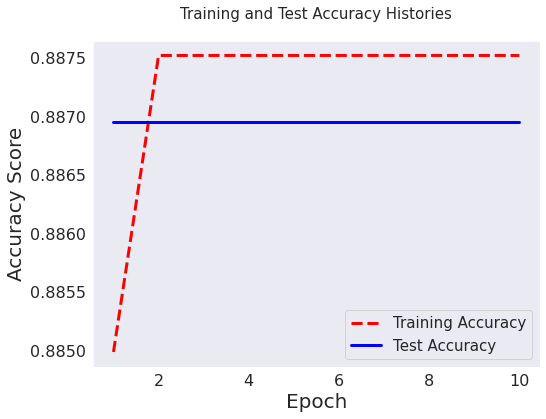

In [40]:
print(history.history.keys())

# Get training and test accuracy histories
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

import matplotlib.pyplot as plt
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.title("Training and Test Accuracy Histories")
plt.ylabel("Accuracy Score")
plt.show()

Evaluate

In [17]:
# Predict the output for our test dataset. 
# If the prediction is greater than 0.5 then the output is 1 else the output is 0
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[10969     0]
 [ 1388     0]]


Visualizing Neural Networks

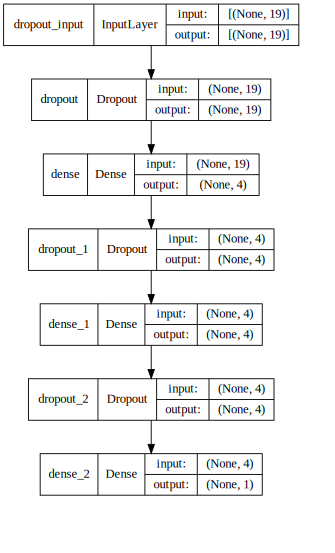

In [18]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(classifier, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))